# Cosmic Neighbours

In this project we are adding a time dimension to the famous [Drake Equation](https://en.wikipedia.org/wiki/Drake_equation). The Drake Equation is as follows:
    
#### N = Rs * fp * ne * fl * fi * fc * L
    where:
    N = number of civilizations with which humans could communicate
    Rs = mean rate of star formation
    fp = fraction of stars that have planets
    ne = mean number of planets that could support life per star with planets
    fl = fraction of life-supporting planets that develop life
    fi = fraction of planets with life where life develops intelligence
    fc = fraction of intelligent civilizations that develop communication
    L = mean length of time that civilizations can communicate
    
This solution to the number of civilizations is a steady state solution. Meaning, we cannot use this estimate to estimate the number of extict civilizations in our galaxy.


### Imports

In [40]:
import numpy as np
import pandas as pd
pd.set_option('display.float_format', '{:,.0f}'.format)
from scipy.stats import poisson
from math import factorial, exp
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme()

### The Original Drake Equation

In [41]:
def Drake(Rs, fp, ne, fl, fi, fc, L):
    """
    The Drake Equation
    N = number of civilizations with which humans could communicate
    Rs = mean rate of star formation
    fp = fraction of stars that have planets
    ne = mean number of planets that could support life per star with planets
    fl = fraction of life-supporting planets that develop life
    fi = fraction of planets with life where life develops intelligence
    fc = fraction of intelligent civilizations that develop communication
    L = mean length of time that civilizations can communicate
    """
    return round(Rs * fp * ne * fl * fi * fc * L)


In [60]:
# Using our best estimates, the Drake Equation predicts...
RS = 2  # star formation per galaxy (ie, milky way)
FP = 1
NE = 0.4
FL = 1  # seems optimistic to me
FI = 1  # seems optimistic to me
FC = 0.1  # looks like a complete guess 
L = 1000  # maybe between 1000 and 100_000_000

Drake(RS, FP, NE, FL, FI, FC, L)

80

In [62]:
# hack the Drake equation to estimate how many extict technological civilizations
# might exist in the Milky Way
print(f"{Drake(RS, FP, NE, FL, FI, FC, 15_000_000_000):,}")
# seems a bit high...

1,200,000,000


### Adding Time

##### Step 1: Break It Into Parts

##### PARAMS

In [43]:
# CONSTANTS

# best estimate for a solution to the Drake equation
RS = 2  # star formation per galaxy (ie, milky way)
FP = 1
NE = 0.4
FL = 1  # seems optimistic to me
FI = 1  # seems optimistic to me
FC = 0.1  # looks like a complete guess 
L = 1000  # maybe between 1000 and 100_000_000

NUM_GALAXY = 100_000_000_000  # number of stars in a galaxy
MODERN_ERA = 10_000_000_000  # years since 2nd gen stars, order of magnitude approx

# approx timeframe on Earth - assume it is representative
YEARS_PLANETS_TO_HABITABLE = 2_000_000_000
YEARS_HABITABLE_TO_LIFE = 1_000_000_000
YEARS_LIFE_TO_COMPLEX_LIFE = 1_000_000_000
YEARS_COMPLEX_TO_INTELLIGENCE = 200_000_000
YEARS_INTELLIGENCE_TO_TECH = 100_000

# estimates for mass extinctions in years
EXTINCTION_SIMPLE = 5_000_000_000  # approx limit to age of life on earth
EXTINCTION_COMPLEX = 2_000_000_000  # more likely to go extinct
EXTINCTION_INTELLIGENT = 200_000_000  # guess: approx age of the dinosaurs
EXTINCTION_TECHNOLOGICAL = L  # from Drake Equation input parameter

# increments for calculations
YEAR_STEPS = 1_000_000

# variables

num_stars = 0  # number of 2nd+ generation stars
num_planets = 0
num_habitable_planets = 0
num_life = 0
num_complex_life = 0
num_intelligent_life = 0
N = 0  # number of technological lifeforms (NOT A CONSTANT)
current_year = 0  # start at 0

##### STAR FORMATION

In [44]:
# number of stars

def star_formation(current_year, num_stars):
    """
    star birth
    currently 30 times lower than at the start of the universe
    peaked 8 billion years ago
    approx rate calc assumes 30x at 10B ago, and Rs from now forward, linear interpolation
    
    star death
    not based on astro physics, just used to balance the births vs death at num_galaxy
    """
    # star birth
    rate = RS * max(((MODERN_ERA - current_year) * 30) / MODERN_ERA, 1)
    birth = rate * YEAR_STEPS
    
    # star death
    death = rate * YEAR_STEPS * num_stars / NUM_GALAXY
    
    return birth - death
    

##### PLANET FORMATION

In [45]:
# number of new planets
def new_planets(num_new_stars):
    """
    New stars create new planets. These planets are not habitable yet, but 
    they only count if they will become habitable, and will develop life.
    
    Incorporates all of the following Drake parameters:
    fp = fraction of stars that have planets
    ne = mean number of planets that could support life per star with planets
    fl = fraction of life-supporting planets that develop life
    """
    return num_new_stars * FP * NE * FL
    

In [46]:
# number of new planets
def new_habitable(num_planets, num_habitable_planets):
    """
    the number of planets that become habitable
    doesn't track planets, just uses ratios to approximate
    """
    uninhabited = num_planets - num_habitable_planets
    newly_habitable = uninhabited * YEAR_STEPS / YEARS_PLANETS_TO_HABITABLE
    return newly_habitable
    

##### LIFE FORMATION

The following parameters are treated as timeframes instead of ratios:

    fi = fraction of planets with life where life develops intelligence
    fc = fraction of intelligent civilizations that develop communication
    L = mean length of time that civilizations can communicate
    
    #TODO could refactor a few functions into a transition function. maybe too abstract, leave for now

In [47]:
# probability calcs whether something happens over a period
def prob_poisson(avg_time_to_happen, how_many_years_happened):
    """
    use poisson probably
    returns a ratio between 0 and 1
    results work for better known calcs, but fall apart for L
    probability of L is calculated in prob_L()
    """
    return 1 - poisson.cdf(k=1, mu=how_many_years_happened/avg_time_to_happen)


In [48]:
# need a different probability distribution for L
# if the number is between hundreds and millions of years, 
# 0.0000000000000000% is not realistic for 1M yr survival
# what is a probability distribution with fatter tails?
# let's try a Weibull distribution!
# https://en.wikipedia.org/wiki/Weibull_distribution

def prob_L(how_many_years_happened):
    """
    after testing: consider removing inputs, just read L and shift the 
    consider: bypass L and use Lmin and Lmax
    """
    SHAPE_PARAMETER = 0.4  # k
    SCALE_PARAMETER = 20_000  # lambda / 63rd percentile
    # these were chosen to give a 10% extinction at 100yr and 99% at 1M yr
    # approx 50th %ile of 10k years
    # could be optimistic
    # tweak as desired
    
    return 1 - exp(-(how_many_years_happened/SCALE_PARAMETER)**SHAPE_PARAMETER)
    

In [49]:
def new_life(num_habitable_planets, num_life):
    """
    the number of habitable planets that develop new life
    doesn't track planets, just uses ratios to approximate
    """
    uninhabited = num_habitable_planets - num_life
    new_lifeforms = uninhabited * prob_poisson(YEARS_HABITABLE_TO_LIFE, YEAR_STEPS)
    return new_lifeforms

In [50]:
def new_complex_life(num_life, num_complex_life):
    """
    the number of planets with life that develop complex life
    doesn't track planets, just uses ratios to approximate
    """
    primitive_life = num_life - num_complex_life
    new_complex = primitive_life * prob_poisson(YEARS_LIFE_TO_COMPLEX_LIFE, YEAR_STEPS)
    return new_complex

In [51]:
def new_intelligence(num_complex_life, num_intelligent_life):
    """
    the number of planets with complex life that develop intelligent life
    doesn't track planets, just uses ratios to approximate
    """
    unintelligent = num_complex_life - num_intelligent_life
    intelligent = unintelligent * prob_poisson(YEARS_COMPLEX_TO_INTELLIGENCE, YEAR_STEPS)
    return intelligent

In [52]:
def new_technological(num_intelligent_life, N):
    """
    the number of planets with complex life that develop intelligent life
    doesn't track planets, just uses ratios to approximate
    """
    intelligent = num_intelligent_life - N
    technological = intelligent * prob_poisson(YEARS_INTELLIGENCE_TO_TECH, YEAR_STEPS)
    return technological

In [53]:
def new_extinctions(num_stars, num_life, num_complex_life, num_intelligent_life, N):
    """
    uses estimates for extinction events to subtract lifeforms
    should balance with star death
    """
    # base extinction numbers
    base = RS * YEAR_STEPS * (num_life / num_stars)  # RS and star death balance, correct for % life/stars
    
    # specific extinction numbers
    extinction_simple = base
    extinction_complex = base + num_complex_life * prob_poisson(EXTINCTION_COMPLEX, YEAR_STEPS)
    extinction_intelligent = base + num_intelligent_life * prob_poisson(EXTINCTION_INTELLIGENT, YEAR_STEPS)
    extinction_technological = N * prob_L(YEAR_STEPS)
    
    return extinction_simple, extinction_complex, extinction_intelligent, extinction_technological

##### Step 2: Tune the Parts to Match Reality and Drake Params

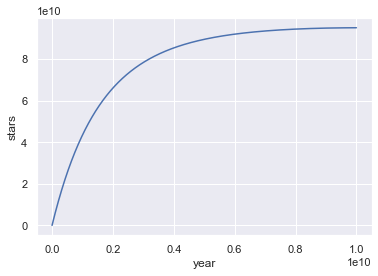

In [54]:
# test number of stars by plotting

starplot = [[0, 0]]  # year, stars

for n in range(MODERN_ERA // YEAR_STEPS):
    temp_year = starplot[-1][0]
    temp_stars = starplot[-1][1]
    temp_stars += star_formation(temp_year, temp_stars)
    starplot.append([(n+1)*YEAR_STEPS, temp_stars])

starplot = pd.DataFrame(starplot, columns=['year', 'stars'])

sns.lineplot(x=starplot.year, y=starplot.stars);

In [55]:
starplot.tail()

,year,stars
9996,9996000000,"95,041,880,517"
9997,9997000000,"95,041,979,679"
9998,9998000000,"95,042,078,840"
9999,9999000000,"95,042,177,998"
10000,10000000000,"95,042,277,155"


In [56]:
# fix probability calcs to be between 0 and 1
# https://www.statology.org/poisson-distribution-python/

def prob_happens(avg_time_to_happen, how_many_years_happened):
    """
    use poisson probably
    returns a ratio between 0 and 1
    """
    return 1 - poisson.cdf(k=1, mu=how_many_years_happened/avg_time_to_happen)


In [57]:
# need a different probability distribution for L
# if the number is between hundreds and millions of years, 
# 0.0000000000000000% is not realistic for 1M yr survival
# what is a probability distribution with fatter tails?
# let's try a Weibull distribution!
# https://en.wikipedia.org/wiki/Weibull_distribution

def prob_L(how_many_years_happened):
    """
    after testing: consider removing inputs, just read L and shift the 
    consider: bypass L and use Lmin and Lmax
    """
    SHAPE_PARAMETER = 0.4  # k
    SCALE_PARAMETER = 20_000  # lambda / 63rd percentile
    # these were chosen to give a 10% extinction at 100yr and 99% at 1M yr
    # approx 50th %ile of 10k years
    # could be optimistic
    # tweak as desired
    
    return round(1 - exp(-(how_many_years_happened/SCALE_PARAMETER)**SHAPE_PARAMETER), 5)
    
prob_L(100), prob_L(1000000), prob_L(10000)

(0.11318, 0.99162, 0.53133)

In [ ]:
# test that functions add up to Drake params



##### Step 3:Combine The Parts

In [ ]:
# OLD VERSION TOO COMPLICATED

def TimeDependentDrake(Rs, fp, ne, fl, fi, fc, L, 
    year=10_000_000_000, # default = NOW, approx 10B yr since 2nd gen stars
    avg_years_to_form_life=4_000_000_000, # approx 4B yr star to first life
    avg_years_to_get_intelligence=1_000_000_000): # approx 1B yr until intelligence

    """
    based on the Drake Equation but incorporates time.
    year is the approximate years since second generation stars formed
        life was unlikely in a first generation star
        10 billion years is an order of magnitude approximation

    avg_years_to_form_life assumes life is inevitable, but takes time to form
        could be thousands, millions, or billions of years

    The Drake Equation
    N = number of civilizations with which humans could communicate
    Rs = mean rate of star formation
    fp = fraction of stars that have planets
    ne = mean number of planets that could support life per star with planets
    fl = fraction of life-supporting planets that develop life
    fi = fraction of planets with life where life develops intelligence
    fc = fraction of intelligent civilizations that develop communication
    L = mean length of time that civilizations can communicate
    """

    star_lifetime = 10_000_000_000  # using a star like the sun

    num_stars = 0
    num_planets = 0
    num_life = 0
    N = 0
    current_year = 0
    year_steps = 1_000_000
    
    # this is NOT probabilistic, just expected values, using fractions
    # next iteration could use Poisson and Monte Carlo 
    chance_of_life = year_steps / avg_years_to_form_life
    chance_of_intelligence = year_steps / avg_years_to_get_intelligence

    while current_year < year:

        # increment times affect approximations
        current_year += year_steps
        new_stars = Rs * year_steps
        dying_stars = num_stars * year_steps / star_lifetime

        # intelligence, then life, then planet, then star formation
        # so that each of these builds off the previous generation

        # fi = fraction of planets with life where life develops intelligence
        # only includes specied that will communicate
        N -= N * year_steps / L  # minus extinctions
        N = max(N, 0)
        N += (num_life - N) * chance_of_intelligence * fc
        # N *= L / year_steps  # use a factor, not exact lifetime
        

        # fl = fraction of life-supporting planets that develop life
        num_life += (num_planets - num_life) * chance_of_life  # only new life

        # planet formation in habitable zones
        # only new stars make new planets
        num_planets += fp * ne * new_stars
        num_planets -= fp * ne * dying_stars  # SUBTRACT DEAD STARS

        # star formation
        num_stars += Rs * year_steps
        num_stars -= dying_stars  # SUBTRACT DEAD STARS

    # N is the number of civilizations born this timestep
    N = N / year_steps  # normalise - intelligent at any given time

    return round(N)

In [ ]:
TimeDependentDrake(Rs, fp, ne, fl, fi, fc, L, year=10_000_000_000)

In [ ]:
TimeDependentDrake(Rs, fp, ne, fl, fi, fc, 100000000000000000, year=10_000_000_000)

In [ ]:
TimeDependentDrake(Rs, fp, ne, fl, fi, fc, L, year=1_000_000_000_000)

In [ ]:
# best estimate for a solution to the Drake equation

Rs = 2  # star formation per galaxy (ie, milky way)
fp = 1
ne = 0.4
fl = 1  # seems optimistic to me
fi = 1  # seems optimistic to me
fc = 0.1  # looks like a complete guess 
L = 1000  # maybe between 1000 and 100_000_000

# Time Independent Drake Equation is the steady state solution
TimeDependentDrake(Rs, fp, ne, fl, fi, fc, L, year=10_000_000_000)

In [ ]:
for i in [0, 1, 10, 100, 1000, 10000]:
    print(TimeDependentDrake(Rs, fp, ne, fl, fi, fc, L, year=i*1000000000))

In [ ]:
Drake(Rs, fp, ne, fl, fi, fc, L)

# Graph it

In [ ]:
# def DrakeTime(year):
#     Rs = 2  # star formation per galaxy (ie, milky way)
#     fp = 1
#     ne = 0.4
#     fl = 1  # seems optimistic to me
#     fi = 1  # seems optimistic to me
#     fc = 0.1  # looks like a complete guess 
#     L = 1000  # maybe between 1000 and 100_000_000

#     # Time Independent Drake Equation is the steady state solution
#     return TimeDependentDrake(Rs, fp, ne, fl, fi, fc, L, year=year)

# # WAYYYYYYYYY too slow - rewrite function
# x = [x*1_000_000_000 for x in range(1000)]
# y = [DrakeTime(i) for i in x]

In [ ]:
def DrakeTime(list_of_years):

    """
    takes in a list of years and outputs the N for those years
    """

    end = list_of_years[-1]
    increment = list_of_years[1] - list_of_years[0]

    # CONSTANTS
    Rs = 2
    fp = 1
    ne = 0.4
    fl = 1
    fi = 1
    fc = 0.1
    L = 1000
    avg_years_to_form_life = 4_000_000_000
    avg_years_to_get_intelligence = 1_000_000_000

    # Variables
    num_stars = 0
    num_planets = 0
    num_life = 0
    N_list = []
    N = 0
    current_year = 0
    year_steps = 1_000_000

    # ADD ERROR CHECKING
    # year steps should include all inputted years
    if increment % year_steps != 0:
        pass
    
    chance_of_life = year_steps / avg_years_to_form_life
    chance_of_intelligence = year_steps / avg_years_to_get_intelligence

    while current_year < end:

        # increment times affect approximations
        current_year += year_steps
        new_stars = Rs * year_steps

        # intelligence, then life, then planet, then star formation
        # so that each of these builds off the previous generation

        # fi = fraction of planets with life where life develops intelligence
        # only includes specied that will communicate
        N += (num_life - N) * chance_of_intelligence * fc
                
        # minus extinctions
        N *= (L / year_steps)

        # fl = fraction of life-supporting planets that develop life
        num_life += (num_planets - num_life) * chance_of_life  # only new life

        # planet formation in habitable zones
        num_planets += fp * ne * new_stars  # only new stars make new planets

        # star formation
        num_stars += Rs * year_steps

        if current_year in list_of_years:
            N_list.append(round(N * L / year_steps))

    return N_list

In [ ]:
x = [x*1_000_000_000 for x in range(1,1001)]
y = DrakeTime(x)

In [ ]:
sns.lineplot(y=y, x=x)

In [ ]:
TimeDependentDrake(Rs, fp, ne, fl, fi, fc, L, year=1_000_000_000_000)

In [ ]:
TimeDependentDrake(Rs, fp, ne, fl, fi, fc, L, year=100_000_000_000_000)

In [ ]:
#  ERROR CHECKING
# year steps should include all inputted years
year_steps = 2300000
increment = 1000000000

# if increment % year_steps != 0:
#     increment // year_steps
#     year_steps = increment // (increment // year_steps)

# year_steps


new = increment / round(increment / year_steps)
new
